<a href="https://www.kaggle.com/code/emrearuk/nlp-disaster-tweets?scriptVersionId=116124015" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [116]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [117]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [118]:
import optuna
import pandas as pd
import numpy as np
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold, KFold,train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,plot_confusion_matrix,classification_report
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torch.optim as optim
from nltk.stem import WordNetLemmatizer # lemmatizier
import time

pd.options.display.max_rows=250
pd.options.display.max_columns=250
pd.options.display.max_colwidth=50

from tqdm import tqdm,tqdm_notebook
tqdm.pandas(desc='my bar')

import warnings
warnings.filterwarnings('ignore')

import sys
sys.setrecursionlimit(10000)

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)

import re
def preprocessing(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    
    s = removeHTML(s)
    s = re.sub("@\w+", '',s) # removing mentions (@)
#     s = re.sub("'\d+", '',s)
#     s = re.sub("\d+", '',s)
    s = re.sub(r"[^\w\s]", '',s) # to remove symbols
    s = re.sub("http\w+", '',s)
    s = re.sub("\s[a-z]\s", '',s)
    s = s.strip()
    
    return s

from nltk.corpus import stopwords
# load stop words
stop_word = stopwords.words('english')

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
device

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


device(type='cuda')

In [119]:
train=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train.info()
print(f'\n\n')
train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB





,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [120]:
test=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test.info()
print(f'\n\n')
test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB





,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


data shhape:  (10876, 2)
7613


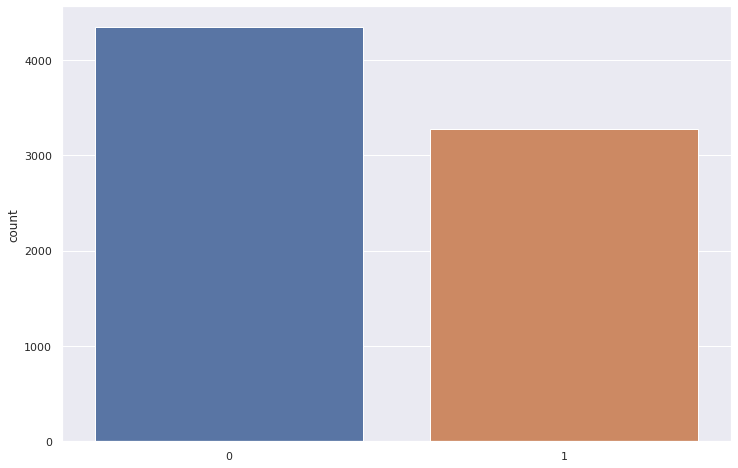

In [121]:
data=pd.concat([train,test])[['text','target']].reset_index(drop='True')
label=train['target'].values
print(f'data shhape: ',data.shape)
print(len(label))

sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(label);

In [122]:
data.text

0        Our Deeds are the Reason of this #earthquake M...
1                   Forest fire near La Ronge Sask. Canada
2        All residents asked to 'shelter in place' are ...
3        13,000 people receive #wildfires evacuation or...
4        Just got sent this photo from Ruby #Alaska as ...
                               ...                        
10871    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
10872    Storm in RI worse than last hurricane. My city...
10873    Green Line derailment in Chicago http://t.co/U...
10874    MEG issues Hazardous Weather Outlook (HWO) htt...
10875    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 10876, dtype: object

In [123]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

data['text']=data['text'].apply(lambda x : remove_URL(x))

In [124]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

data['text']=data['text'].apply(lambda x : remove_html(x))

In [125]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


data['text']=data['text'].apply(lambda x: remove_emoji(x))

In [126]:
import string
special = string.punctuation

In [127]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
data['text']=data['text'].apply(lambda x : remove_punct(x))

In [128]:
# from spellchecker import SpellChecker

# spell = SpellChecker()
# def correct_spellings(text):
#     corrected_text = []
#     misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)
        
# text = "corect me plese"
# correct_spellings(text)

In [130]:
from nltk.corpus import stopwords

def tokenizer(texts):
    word_list=[]
    stop_word=set(stopwords.words('english'))
    for sent in texts:
        sent=sent.lower().split()
        for word in sent:
#             word=preprocessing(word)
            if word not in word_list :#stop_word and word != '' :
    
                word_list.append(word)
    
    corpus=Counter(word_list)     
    corpus_=sorted(corpus,key=corpus.get,reverse=True)
    one_hot_dict={w:i+1 for i,w in enumerate(corpus_)}
    
    
    train_list=[]
    for  sent in  texts:   
         train_list.append( [one_hot_dict[word] for word in sent.lower().split()
                           if word in one_hot_dict.keys()])
    
    
    
    
    return  train_list,one_hot_dict
        
data_text,one_hot_dict=tokenizer(data.text)

In [132]:
a=[len(x) for x in data_text]
max_len_index=a.index(max(a))
max_len_seq=len(data_text[max_len_index])
print(f'max length squence :{max_len_seq}')

#padding used to same size tensors
pad=max_len_seq
def padding(data,padd):
    for i,sent in enumerate(data):
        feature=np.zeros((1,padd),dtype=int) 
        if len(np.array(sent)) != 0:
            feature[:,-len(sent):]=np.array(sent)
            data[i]=feature
        else :
            data[i]=feature
    return data


data_text_padded=padding(data_text,pad) 
data_text_padded=np.array(data_text_padded)
print(f'data_text_padded shape: ',data_text_padded.shape)
data_train=data_text_padded[:train.shape[0]]
target_train=label
print(f'data train shape : {data_train.shape}')
print(f'Target train shape {target_train.shape}')

max length squence :31
data_text_padded shape:  (10876, 1, 31)
data train shape : (7613, 1, 31)
Target train shape (7613,)


In [149]:
data_train

array([[[   0,    0,    0, ..., 3619,   67,   40]],

       [[   0,    0,    0, ..., 8212, 8213, 1371]],

       [[   0,    0,    0, ..., 1617,   21, 1208]],

       ...,

       [[   0,    0,    0, ...,    6,  519, 1517]],

       [[   0,    0,    0, ..., 6326, 2273,  305]],

       [[   0,    0,    0, ...,  167,  609,   54]]])

In [133]:
data=TensorDataset(torch.tensor(np.array(data_train)),torch.tensor(target_train))
df_test=data_text_padded[len(target_train):]
print(f'Train data shape: {data_train.shape}')
print(f'Train data label shape: {label.shape}')
print(f'Test data shape: {df_test.shape}')

Train data shape: (7613, 1, 31)
Train data label shape: (7613,)
Test data shape: (3263, 1, 31)


In [161]:
class sentimentLSTM(nn.Module):
    def __init__(self,num_layers,batch_size,hidden_size,vocab_size,embed_size,p,pad):
        super(sentimentLSTM,self).__init__()
        
        self.hidden_size=hidden_size
        self.embed=nn.Embedding(vocab_size,embed_size)
        self.embed_size=embed_size
        self.num_layers=num_layers
        self.prob=p
        self.pad=pad
        self.lstm=nn.LSTM(input_size=self.embed_size,
                         hidden_size=self.hidden_size,
                         num_layers=self.num_layers,
                         batch_first=True)
        

        
        
        self.linear=nn.Linear(self.hidden_size,512)
        self.linear2=nn.Linear(512,64)
        self.linear3=nn.Linear(64,1)

        self.drop=nn.Dropout(self.prob)
        self.relu=nn.ReLU()
#       self.sigmoid=nn.Sigmoid()
    

    
    def forward(self,init_hidden,batch_input):
        
        batch_sz=batch_input.shape[0]
        batch_input=batch_input.view(batch_sz,-1)
        batch_input=self.embed(batch_input)
        batch_input,hiddens=self.lstm(batch_input,init_hidden)
        batch_input=batch_input.contiguous().view(-1, self.hidden_size)
        
        batch_input=self.drop(batch_input)
        batch_input=self.relu(batch_input)
        batch_input=self.linear(batch_input) 
        
        batch_input=self.drop(batch_input)
        batch_input=self.relu(batch_input)
        batch_input=self.linear2(batch_input)  
        
        batch_input=self.drop(batch_input)
        batch_input=self.relu(batch_input)
        batch_input=self.linear3(batch_input)  
        
        
#       batch_input=self.sigmoid(batch_input)
        out=batch_input.view(batch_sz,self.pad, -1)   
        
        return out[:,-1],hiddens
    
    
    def get_x(self):
        return self.x

    def init_hidden(self,b):

        h0 = torch.zeros((self.num_layers,b,self.hidden_size)).to(device)
        c0 = torch.zeros((self.num_layers,b,self.hidden_size)).to(device)
        hidden = (h0,c0)
        return hidden

In [144]:
# Train and evaluate the accuarcy of neural network model
def objective(trial,sentimentLSTM=sentimentLSTM,data=data,target=target_train):

    params = {'num_layers':trial.suggest_categorical('num_layers', [1,2]),
              'batch_size':trial.suggest_categorical('batch_size', [64,128,256,512]),
              'hidden_size':trial.suggest_categorical('hidden_size', [50,100,200]),
              'vocab_size':trial.suggest_categorical('vocab_size', [28262]),
              'embed_size':trial.suggest_categorical('embed_size', [50,100,200]),
              'prob':trial.suggest_categorical('prob', [0.3,0.5,0.7,0.9]),
              'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.01,0.001]),
              'optimizer': trial.suggest_categorical("optimizer", ['Adam']),
               'pad':trial.suggest_categorical('pad', [31])
              }
    
    model_params={key:value   for key,value in params.items() if key not in('learning_rate','optimizer')}   
    
    kf=KFold(n_splits=3,shuffle=True,random_state=0)
    folds=list(kf.split(data,target))

    history_fold = {'train_f1':{'folds':[]},
                    'train_loss': {'folds':[]},
                    'train_preds':{'folds':[]},
                    'val_loss':{'folds':[]},
                    'val_f1':{'folds':[]},
                    'val_preds':{'folds':[]}}


    for fold,(train_idx, val_idx) in enumerate(folds):
        
        print(f'fold :{fold}')

        lstmModel=sentimentLSTM(**model_params).to(device)

        optimizer = getattr(torch.optim, params['optimizer'])(lstmModel.parameters(),lr=params['learning_rate'])
        criterion=nn.BCEWithLogitsLoss(reduction='sum')

                        
        train_data = TensorDataset(data.tensors[0][train_idx], data.tensors[1][train_idx])
        val_data = TensorDataset(data.tensors[0][val_idx], data.tensors[1][val_idx])

        train_loader=DataLoader(dataset=train_data,
                                shuffle=True,
                                batch_size=params['batch_size'], drop_last=True)

        val_loader=DataLoader(dataset=val_data,
                                shuffle=True,
                                batch_size=params['batch_size'], drop_last=True)

        for epoch in range(10):
            
            lstmModel.train()
            train_loss_sum=0
            train_preds=[]
            train_labels=[]
            h = lstmModel.init_hidden(params['batch_size'])


            for batch_idx,(train_inputs,train_label) in enumerate(train_loader):

                train_inputs=train_inputs.type(torch.LongTensor).to(device)
                train_label=train_label.type(torch.LongTensor).to(device)

                h = tuple([each.data for each in h])
        
                train_pred,hd=lstmModel(h,train_inputs) 
            
                optimizer.zero_grad()
                train_batch_loss=criterion(train_pred.float(),train_label.reshape(-1,1).float())
                train_batch_loss.backward()
                optimizer.step()
                
                train_loss_sum+=train_batch_loss.item() 
                train_labels.append(np.array(train_label.cpu()))
                train_preds.append(np.array([1 if i>0.3 else 0 for i in train_pred]))




            f1_train=f1_score(np.concatenate(train_labels),np.concatenate(train_preds))  
    
            history_fold['train_f1']['folds'].append({'fold_'+str(fold):f1_train})
            history_fold['train_loss']['folds'].append({'fold_'+str(fold):train_loss_sum})
            history_fold['train_preds']['folds'].append({'fold_'+str(fold):np.concatenate(train_preds)})

            
            lstmModel.eval() 
            val_loss_sum=0
            val_preds=[]
            val_labels=[]
            for batch_idx,(val_inputs,val_label) in enumerate(val_loader):

                val_inputs=val_inputs.type(torch.LongTensor).to(device)
                val_label=val_label.type(torch.LongTensor).to(device)

                h= tuple([each.data for each in h])
                val_pred,hd=lstmModel(h,val_inputs)
                
                val_batch_loss=criterion(val_pred.float(),val_label.reshape(-1,1).float())
                val_loss_sum+=val_batch_loss.item()


                val_labels.append(np.array(val_label.cpu()))
                val_preds.append(np.array([1 if i>0.3 else 0 for i in val_pred]))


            f1_val=f1_score(np.concatenate(val_labels),np.concatenate(val_preds))
            
            history_fold['val_f1']['folds'].append({'fold_'+str(fold):f1_val})
            history_fold['val_loss']['folds'].append({'fold_'+str(fold):val_loss_sum})
            history_fold['val_preds']['folds'].append({'fold_'+str(fold):np.concatenate(val_preds)})


            
            print(f'Epoch : {epoch}, Train_mean_f1 : {f1_train} ,Train_total_loss : {train_loss_sum} >----< validation_mean_f1 : {f1_val} ,Validation_total_loss : {val_loss_sum}')
     
    

    validation_f1=pd.DataFrame([pd.DataFrame(history_fold['val_f1']['folds'])[col].dropna().values  for col in pd.DataFrame(history_fold['val_f1']['folds']).columns]).mean(axis=0).max()
    train_f1=pd.DataFrame([pd.DataFrame(history_fold['train_f1']['folds'])[col].dropna().values  for col in pd.DataFrame(history_fold['val_f1']['folds']).columns]).mean(axis=0).max()

    trial.set_user_attr("history", history_fold)
    print(f"train f1 : {train_f1} >----< f1 score : {validation_f1}") 
    print(f'\n\n')

    return validation_f1


EPOCHS = 30
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-11 20:45:00,436] A new study created in memory with name: no-name-965e4ae4-28ab-4454-829d-26dc01885f8e


fold :0
Epoch : 0, Train_mean_f1 : 0.0 ,Train_total_loss : 3418.406295776367 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1626.7152252197266
Epoch : 1, Train_mean_f1 : 0.5691290600747342 ,Train_total_loss : 2813.460081100464 >----< validation_mean_f1 : 0.6600522193211488 ,Validation_total_loss : 1352.969596862793
Epoch : 2, Train_mean_f1 : 0.8137086903304772 ,Train_total_loss : 1851.2613983154297 >----< validation_mean_f1 : 0.6698262243285941 ,Validation_total_loss : 1379.7280979156494
Epoch : 3, Train_mean_f1 : 0.8982007575757576 ,Train_total_loss : 1171.0673322677612 >----< validation_mean_f1 : 0.6670335718216841 ,Validation_total_loss : 1648.6682872772217
Epoch : 4, Train_mean_f1 : 0.9349442379182156 ,Train_total_loss : 759.9008810520172 >----< validation_mean_f1 : 0.6683168316831684 ,Validation_total_loss : 1862.6695652008057
Epoch : 5, Train_mean_f1 : 0.9569223681179452 ,Train_total_loss : 538.2166361808777 >----< validation_mean_f1 : 0.690230731467845 ,Validation_tota

[I 2023-01-11 20:45:31,479] Trial 0 finished with value: 0.6991016794899595 and parameters: {'num_layers': 1, 'batch_size': 64, 'hidden_size': 100, 'vocab_size': 28262, 'embed_size': 200, 'p': 0.3, 'learning_rate': 0.001, 'optimizer': 'Adam', 'pad': 31}. Best is trial 0 with value: 0.6991016794899595.


Epoch : 9, Train_mean_f1 : 0.9796109678931333 ,Train_total_loss : 249.93595013022423 >----< validation_mean_f1 : 0.6943105110896818 ,Validation_total_loss : 2972.793842315674
train f1 : 0.9778832740965718 >----< f1 score : 0.6991016794899595



fold :0
Epoch : 0, Train_mean_f1 : 0.033751205400192864 ,Train_total_loss : 3208.5126037597656 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1399.8519897460938
Epoch : 1, Train_mean_f1 : 0.02330097087378641 ,Train_total_loss : 3193.7012939453125 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1401.9170227050781
Epoch : 2, Train_mean_f1 : 0.006906758756783423 ,Train_total_loss : 3154.38720703125 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1393.4514465332031
Epoch : 3, Train_mean_f1 : 0.004935834155972358 ,Train_total_loss : 3169.8497314453125 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1395.2197875976562
Epoch : 4, Train_mean_f1 : 0.0029702970297029703 ,Train_total_loss : 3160.2953186035156 >----< val

[I 2023-01-11 20:45:44,325] Trial 1 finished with value: 0.0 and parameters: {'num_layers': 1, 'batch_size': 512, 'hidden_size': 100, 'vocab_size': 28262, 'embed_size': 50, 'p': 0.9, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 0 with value: 0.6991016794899595.


Epoch : 9, Train_mean_f1 : 0.0 ,Train_total_loss : 3067.585174560547 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1389.9010925292969
train f1 : 0.046090927694794774 >----< f1 score : 0.0



fold :0
Epoch : 0, Train_mean_f1 : 0.0 ,Train_total_loss : 3334.5316467285156 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1564.3607940673828
Epoch : 1, Train_mean_f1 : 0.0 ,Train_total_loss : 3319.5086059570312 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1561.4622650146484
Epoch : 2, Train_mean_f1 : 0.0 ,Train_total_loss : 3298.8409423828125 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1551.8263244628906
Epoch : 3, Train_mean_f1 : 0.0 ,Train_total_loss : 3234.211883544922 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1506.0431671142578
Epoch : 4, Train_mean_f1 : 0.12966938600257621 ,Train_total_loss : 3013.555953979492 >----< validation_mean_f1 : 0.5426356589147286 ,Validation_total_loss : 1380.8604431152344
Epoch : 5, Train_mean_f1 : 0.60

[I 2023-01-11 20:46:00,142] Trial 2 finished with value: 0.7020629391578472 and parameters: {'num_layers': 2, 'batch_size': 256, 'hidden_size': 50, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.7, 'learning_rate': 0.001, 'optimizer': 'Adam', 'pad': 31}. Best is trial 2 with value: 0.7020629391578472.


Epoch : 9, Train_mean_f1 : 0.8839396189062113 ,Train_total_loss : 1373.760585784912 >----< validation_mean_f1 : 0.7199587416193914 ,Validation_total_loss : 1369.100601196289
train f1 : 0.8796049609066176 >----< f1 score : 0.7020629391578472



fold :0
Epoch : 0, Train_mean_f1 : 0.0009995002498750627 ,Train_total_loss : 3122.9598693847656 >----< validation_mean_f1 : 0.03460207612456747 ,Validation_total_loss : 1330.1072387695312
Epoch : 1, Train_mean_f1 : 0.5226098191214471 ,Train_total_loss : 2692.8873596191406 >----< validation_mean_f1 : 0.635897435897436 ,Validation_total_loss : 1154.4335021972656
Epoch : 2, Train_mean_f1 : 0.7684702004943696 ,Train_total_loss : 1926.5739440917969 >----< validation_mean_f1 : 0.598679383712399 ,Validation_total_loss : 1146.1370544433594
Epoch : 3, Train_mean_f1 : 0.8621778011572856 ,Train_total_loss : 1331.9927673339844 >----< validation_mean_f1 : 0.6989576946658491 ,Validation_total_loss : 1364.2950744628906
Epoch : 4, Train_mean_f1 : 0.9239948119325

[I 2023-01-11 20:46:12,969] Trial 3 finished with value: 0.7057519916411307 and parameters: {'num_layers': 1, 'batch_size': 512, 'hidden_size': 50, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 3 with value: 0.7057519916411307.


Epoch : 9, Train_mean_f1 : 0.9795186891961086 ,Train_total_loss : 236.2944679260254 >----< validation_mean_f1 : 0.6948198198198198 ,Validation_total_loss : 2613.1951904296875
train f1 : 0.9803797593116061 >----< f1 score : 0.7057519916411307



fold :0
Epoch : 0, Train_mean_f1 : 0.09267840593141798 ,Train_total_loss : 3113.470245361328 >----< validation_mean_f1 : 0.6017910447761194 ,Validation_total_loss : 1359.9599914550781
Epoch : 1, Train_mean_f1 : 0.6083112290008843 ,Train_total_loss : 2578.915283203125 >----< validation_mean_f1 : 0.605972323379461 ,Validation_total_loss : 1094.6663208007812
Epoch : 2, Train_mean_f1 : 0.8028516588977243 ,Train_total_loss : 1741.3417510986328 >----< validation_mean_f1 : 0.6962872793670115 ,Validation_total_loss : 1132.78369140625
Epoch : 3, Train_mean_f1 : 0.8986945169712792 ,Train_total_loss : 1119.132194519043 >----< validation_mean_f1 : 0.7286063569682152 ,Validation_total_loss : 1417.9949035644531
Epoch : 4, Train_mean_f1 : 0.9363122752953262 ,T

[I 2023-01-11 20:46:26,675] Trial 4 finished with value: 0.7082961025413838 and parameters: {'num_layers': 1, 'batch_size': 512, 'hidden_size': 100, 'vocab_size': 28262, 'embed_size': 200, 'p': 0.5, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 4 with value: 0.7082961025413838.


Epoch : 9, Train_mean_f1 : 0.9817808570695408 ,Train_total_loss : 193.9638376235962 >----< validation_mean_f1 : 0.7066508313539193 ,Validation_total_loss : 2849.9508056640625
train f1 : 0.9799812775360827 >----< f1 score : 0.7082961025413838



fold :0
Epoch : 0, Train_mean_f1 : 0.023339317773788153 ,Train_total_loss : 3451.251304626465 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1668.7712631225586
Epoch : 1, Train_mean_f1 : 0.005479452054794521 ,Train_total_loss : 3447.4405059814453 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1668.1796264648438
Epoch : 2, Train_mean_f1 : 0.0009178522257916476 ,Train_total_loss : 3427.8136444091797 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1661.9730377197266
Epoch : 3, Train_mean_f1 : 0.001838235294117647 ,Train_total_loss : 3409.568893432617 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1654.5308303833008
Epoch : 4, Train_mean_f1 : 0.0009216589861751151 ,Train_total_loss : 3380.8633422851562 >----< v

[I 2023-01-11 20:46:49,037] Trial 5 finished with value: 0.2304675716440422 and parameters: {'num_layers': 2, 'batch_size': 128, 'hidden_size': 50, 'vocab_size': 28262, 'embed_size': 200, 'p': 0.9, 'learning_rate': 0.001, 'optimizer': 'Adam', 'pad': 31}. Best is trial 4 with value: 0.7082961025413838.


Epoch : 9, Train_mean_f1 : 0.0 ,Train_total_loss : 2912.549659729004 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1495.3246765136719
train f1 : 0.11413748378728922 >----< f1 score : 0.2304675716440422



fold :0
Epoch : 0, Train_mean_f1 : 0.11989100817438693 ,Train_total_loss : 3636.038242340088 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1701.254222869873
Epoch : 1, Train_mean_f1 : 0.053119730185497475 ,Train_total_loss : 3571.3764839172363 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1701.002758026123
Epoch : 2, Train_mean_f1 : 0.015212527964205814 ,Train_total_loss : 3494.069004058838 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1697.8069458007812
Epoch : 3, Train_mean_f1 : 0.030061892130857647 ,Train_total_loss : 3482.3389778137207 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1699.0929908752441
Epoch : 4, Train_mean_f1 : 0.008097165991902834 ,Train_total_loss : 3469.9335136413574 >----< validation_mean_f1 : 0.0 ,Validatio

[I 2023-01-11 20:47:16,174] Trial 6 finished with value: 0.0 and parameters: {'num_layers': 1, 'batch_size': 64, 'hidden_size': 50, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.9, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 4 with value: 0.7082961025413838.


Epoch : 9, Train_mean_f1 : 0.010087116001834021 ,Train_total_loss : 3466.510341644287 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1712.305191040039
train f1 : 0.11364443244475221 >----< f1 score : 0.0



fold :0
Epoch : 0, Train_mean_f1 : 0.1195840554592721 ,Train_total_loss : 3269.407485961914 >----< validation_mean_f1 : 0.5836298932384342 ,Validation_total_loss : 1377.0292205810547
Epoch : 1, Train_mean_f1 : 0.6672268907563025 ,Train_total_loss : 2523.830726623535 >----< validation_mean_f1 : 0.6897654584221748 ,Validation_total_loss : 1257.1280670166016
Epoch : 2, Train_mean_f1 : 0.8294672444557736 ,Train_total_loss : 1659.514259338379 >----< validation_mean_f1 : 0.646095717884131 ,Validation_total_loss : 1295.78125
Epoch : 3, Train_mean_f1 : 0.9155985489721886 ,Train_total_loss : 1062.5580444335938 >----< validation_mean_f1 : 0.6889596602972399 ,Validation_total_loss : 1459.478042602539
Epoch : 4, Train_mean_f1 : 0.945939393939394 ,Train_total_loss : 668.6412410736084 >

[I 2023-01-11 20:47:32,349] Trial 7 finished with value: 0.6957934563944738 and parameters: {'num_layers': 1, 'batch_size': 256, 'hidden_size': 200, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.5, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 4 with value: 0.7082961025413838.


Epoch : 9, Train_mean_f1 : 0.9777886258237736 ,Train_total_loss : 242.6046974658966 >----< validation_mean_f1 : 0.6898768077129084 ,Validation_total_loss : 3766.1627502441406
train f1 : 0.9792074017047764 >----< f1 score : 0.6957934563944738



fold :0
Epoch : 0, Train_mean_f1 : 0.13497942386831274 ,Train_total_loss : 3345.489273071289 >----< validation_mean_f1 : 0.21243523316062174 ,Validation_total_loss : 1482.9628524780273
Epoch : 1, Train_mean_f1 : 0.7079091620986687 ,Train_total_loss : 2481.767074584961 >----< validation_mean_f1 : 0.6910935738444194 ,Validation_total_loss : 1327.5598678588867
Epoch : 2, Train_mean_f1 : 0.8540593573706156 ,Train_total_loss : 1523.4392395019531 >----< validation_mean_f1 : 0.7038581856100105 ,Validation_total_loss : 1342.429599761963
Epoch : 3, Train_mean_f1 : 0.9240236686390533 ,Train_total_loss : 908.5061283111572 >----< validation_mean_f1 : 0.7022391615054788 ,Validation_total_loss : 1778.9455032348633
Epoch : 4, Train_mean_f1 : 0.952559009114279 

[I 2023-01-11 20:47:51,113] Trial 8 finished with value: 0.7017281880679 and parameters: {'num_layers': 1, 'batch_size': 128, 'hidden_size': 100, 'vocab_size': 28262, 'embed_size': 50, 'p': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 4 with value: 0.7082961025413838.


Epoch : 9, Train_mean_f1 : 0.9754936949797763 ,Train_total_loss : 246.79912093281746 >----< validation_mean_f1 : 0.6563169164882227 ,Validation_total_loss : 3947.21142578125
train f1 : 0.9786650112379555 >----< f1 score : 0.7017281880679



fold :0
Epoch : 0, Train_mean_f1 : 0.47175667287399137 ,Train_total_loss : 3106.990613937378 >----< validation_mean_f1 : 0.693048128342246 ,Validation_total_loss : 1258.706787109375
Epoch : 1, Train_mean_f1 : 0.7982040409079572 ,Train_total_loss : 2018.1197118759155 >----< validation_mean_f1 : 0.7139188495120699 ,Validation_total_loss : 1259.7301559448242
Epoch : 2, Train_mean_f1 : 0.9050094517958412 ,Train_total_loss : 1088.322384595871 >----< validation_mean_f1 : 0.7081243731193582 ,Validation_total_loss : 1710.1061096191406
Epoch : 3, Train_mean_f1 : 0.9568229046409605 ,Train_total_loss : 532.2712228298187 >----< validation_mean_f1 : 0.7013752455795678 ,Validation_total_loss : 2310.582004547119
Epoch : 4, Train_mean_f1 : 0.9639556377079482 ,Train

[I 2023-01-11 20:48:24,803] Trial 9 finished with value: 0.7164602887578964 and parameters: {'num_layers': 2, 'batch_size': 64, 'hidden_size': 100, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 9 with value: 0.7164602887578964.


Epoch : 9, Train_mean_f1 : 0.9773264052905055 ,Train_total_loss : 226.96965867839754 >----< validation_mean_f1 : 0.7128618889416232 ,Validation_total_loss : 4662.097389221191
train f1 : 0.9802010875487239 >----< f1 score : 0.7164602887578964



fold :0
Epoch : 0, Train_mean_f1 : 0.30046279814880744 ,Train_total_loss : 3291.835075378418 >----< validation_mean_f1 : 0.41281669150521605 ,Validation_total_loss : 1437.7001914978027
Epoch : 1, Train_mean_f1 : 0.7507060333761232 ,Train_total_loss : 2235.003839492798 >----< validation_mean_f1 : 0.6598187311178247 ,Validation_total_loss : 1286.6497821807861
Epoch : 2, Train_mean_f1 : 0.8805213613323679 ,Train_total_loss : 1398.304015636444 >----< validation_mean_f1 : 0.7227572225038014 ,Validation_total_loss : 1649.6875610351562
Epoch : 3, Train_mean_f1 : 0.9367088607594937 ,Train_total_loss : 801.0798132419586 >----< validation_mean_f1 : 0.6849168008588299 ,Validation_total_loss : 1743.7322788238525
Epoch : 4, Train_mean_f1 : 0.9672358098754038

[I 2023-01-11 20:48:59,385] Trial 10 finished with value: 0.7098711677545543 and parameters: {'num_layers': 2, 'batch_size': 64, 'hidden_size': 200, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 9 with value: 0.7164602887578964.


Epoch : 9, Train_mean_f1 : 0.976303317535545 ,Train_total_loss : 279.7598816007376 >----< validation_mean_f1 : 0.7002493765586034 ,Validation_total_loss : 5535.696441650391
train f1 : 0.9758347304468704 >----< f1 score : 0.7098711677545543



fold :0
Epoch : 0, Train_mean_f1 : 0.35654221325260677 ,Train_total_loss : 3317.093635559082 >----< validation_mean_f1 : 0.596073765615705 ,Validation_total_loss : 1394.6784973144531
Epoch : 1, Train_mean_f1 : 0.7276485788113696 ,Train_total_loss : 2323.911503791809 >----< validation_mean_f1 : 0.693854748603352 ,Validation_total_loss : 1273.157606124878
Epoch : 2, Train_mean_f1 : 0.8494835218888342 ,Train_total_loss : 1440.3459115028381 >----< validation_mean_f1 : 0.7001023541453428 ,Validation_total_loss : 1461.1548862457275
Epoch : 3, Train_mean_f1 : 0.9328687572590011 ,Train_total_loss : 886.1492779254913 >----< validation_mean_f1 : 0.6977594878829446 ,Validation_total_loss : 2390.5591163635254
Epoch : 4, Train_mean_f1 : 0.9613284804367607 ,Tra

[I 2023-01-11 20:49:34,689] Trial 11 finished with value: 0.7084713427734668 and parameters: {'num_layers': 2, 'batch_size': 64, 'hidden_size': 200, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 9 with value: 0.7164602887578964.


Epoch : 9, Train_mean_f1 : 0.9750353273669335 ,Train_total_loss : 326.8314437754452 >----< validation_mean_f1 : 0.6769690927218345 ,Validation_total_loss : 2901.41548538208
train f1 : 0.9747034951491648 >----< f1 score : 0.7084713427734668



fold :0
Epoch : 0, Train_mean_f1 : 0.43308847013733626 ,Train_total_loss : 3269.494167327881 >----< validation_mean_f1 : 0.6559911651021535 ,Validation_total_loss : 1350.2597980499268
Epoch : 1, Train_mean_f1 : 0.7576145380087024 ,Train_total_loss : 2269.1551418304443 >----< validation_mean_f1 : 0.7118822292323871 ,Validation_total_loss : 1280.5413665771484
Epoch : 2, Train_mean_f1 : 0.881942774705458 ,Train_total_loss : 1413.697585105896 >----< validation_mean_f1 : 0.7147982062780269 ,Validation_total_loss : 1681.6708278656006
Epoch : 3, Train_mean_f1 : 0.9387755102040817 ,Train_total_loss : 786.1963243484497 >----< validation_mean_f1 : 0.7057736720554272 ,Validation_total_loss : 2456.5468425750732
Epoch : 4, Train_mean_f1 : 0.9651993546900208 ,T

[I 2023-01-11 20:50:09,352] Trial 12 finished with value: 0.7118506429615788 and parameters: {'num_layers': 2, 'batch_size': 64, 'hidden_size': 200, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 9 with value: 0.7164602887578964.


Epoch : 9, Train_mean_f1 : 0.9743348245820579 ,Train_total_loss : 291.49419766664505 >----< validation_mean_f1 : 0.7148703956343793 ,Validation_total_loss : 3866.1176414489746
train f1 : 0.9770975127581805 >----< f1 score : 0.7118506429615788



fold :0
Epoch : 0, Train_mean_f1 : 0.06492411467116357 ,Train_total_loss : 3484.334487915039 >----< validation_mean_f1 : 0.0 ,Validation_total_loss : 1622.436752319336
Epoch : 1, Train_mean_f1 : 0.5107958050586058 ,Train_total_loss : 3055.5272846221924 >----< validation_mean_f1 : 0.512542372881356 ,Validation_total_loss : 1360.306797027588
Epoch : 2, Train_mean_f1 : 0.7208423326133909 ,Train_total_loss : 2383.1870651245117 >----< validation_mean_f1 : 0.5958254269449715 ,Validation_total_loss : 1308.5925750732422
Epoch : 3, Train_mean_f1 : 0.8303284761669548 ,Train_total_loss : 1733.742931842804 >----< validation_mean_f1 : 0.7036872501110617 ,Validation_total_loss : 2414.574171066284
Epoch : 4, Train_mean_f1 : 0.8935560859188543 ,Train_total_los

[I 2023-01-11 20:50:43,798] Trial 13 finished with value: 0.7079039988916659 and parameters: {'num_layers': 2, 'batch_size': 64, 'hidden_size': 200, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.7, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 9 with value: 0.7164602887578964.


Epoch : 9, Train_mean_f1 : 0.9667616334283001 ,Train_total_loss : 405.04214257001877 >----< validation_mean_f1 : 0.691721686135094 ,Validation_total_loss : 6799.343795776367
train f1 : 0.9574122495114806 >----< f1 score : 0.7079039988916659



fold :0
Epoch : 0, Train_mean_f1 : 0.4414910858995138 ,Train_total_loss : 3146.446355819702 >----< validation_mean_f1 : 0.6804979253112033 ,Validation_total_loss : 1423.5900745391846
Epoch : 1, Train_mean_f1 : 0.7601552393272962 ,Train_total_loss : 2160.3104724884033 >----< validation_mean_f1 : 0.7022900763358778 ,Validation_total_loss : 1424.7251625061035
Epoch : 2, Train_mean_f1 : 0.8964028776978417 ,Train_total_loss : 1232.8319644927979 >----< validation_mean_f1 : 0.696319018404908 ,Validation_total_loss : 2043.0293807983398
Epoch : 3, Train_mean_f1 : 0.9427374301675978 ,Train_total_loss : 770.1721341609955 >----< validation_mean_f1 : 0.7108603667136811 ,Validation_total_loss : 1512.403226852417
Epoch : 4, Train_mean_f1 : 0.962962962962963 ,Tr

[I 2023-01-11 20:51:18,533] Trial 14 finished with value: 0.7142258657590029 and parameters: {'num_layers': 2, 'batch_size': 64, 'hidden_size': 200, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 9 with value: 0.7164602887578964.


Epoch : 9, Train_mean_f1 : 0.9737029140014214 ,Train_total_loss : 303.3050817847252 >----< validation_mean_f1 : 0.709873417721519 ,Validation_total_loss : 4561.45930480957
train f1 : 0.9739034225591882 >----< f1 score : 0.7142258657590029



fold :0
Epoch : 0, Train_mean_f1 : 0.3823138297872341 ,Train_total_loss : 3219.422618865967 >----< validation_mean_f1 : 0.6439926062846579 ,Validation_total_loss : 1664.1386909484863
Epoch : 1, Train_mean_f1 : 0.7347770700636943 ,Train_total_loss : 2406.3420791625977 >----< validation_mean_f1 : 0.6835957338750636 ,Validation_total_loss : 1361.765884399414
Epoch : 2, Train_mean_f1 : 0.865021770682148 ,Train_total_loss : 1511.6908588409424 >----< validation_mean_f1 : 0.7127385250128931 ,Validation_total_loss : 1509.5410766601562
Epoch : 3, Train_mean_f1 : 0.9310183012670108 ,Train_total_loss : 869.0130579471588 >----< validation_mean_f1 : 0.7025738798856054 ,Validation_total_loss : 1984.376356124878
Epoch : 4, Train_mean_f1 : 0.9581031307550645 ,Trai

[I 2023-01-11 20:51:51,976] Trial 15 finished with value: 0.7049184170241033 and parameters: {'num_layers': 2, 'batch_size': 64, 'hidden_size': 100, 'vocab_size': 28262, 'embed_size': 50, 'p': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 9 with value: 0.7164602887578964.


Epoch : 9, Train_mean_f1 : 0.974068835454974 ,Train_total_loss : 295.26041090488434 >----< validation_mean_f1 : 0.7150890346766635 ,Validation_total_loss : 4536.7401695251465
train f1 : 0.9726697713055567 >----< f1 score : 0.7049184170241033



fold :0
Epoch : 0, Train_mean_f1 : 0.417996171027441 ,Train_total_loss : 3188.706703186035 >----< validation_mean_f1 : 0.6766595289079229 ,Validation_total_loss : 1334.9223461151123
Epoch : 1, Train_mean_f1 : 0.7651418349092769 ,Train_total_loss : 2141.6142978668213 >----< validation_mean_f1 : 0.6587677725118484 ,Validation_total_loss : 1493.5352592468262
Epoch : 2, Train_mean_f1 : 0.8965680473372781 ,Train_total_loss : 1200.8935871124268 >----< validation_mean_f1 : 0.716885743174924 ,Validation_total_loss : 1636.1408500671387
Epoch : 3, Train_mean_f1 : 0.9482678983833718 ,Train_total_loss : 654.1037620306015 >----< validation_mean_f1 : 0.6855941114616194 ,Validation_total_loss : 1689.7993431091309
Epoch : 4, Train_mean_f1 : 0.9640387275242047 ,

[I 2023-01-11 20:52:26,039] Trial 16 finished with value: 0.708981120712298 and parameters: {'num_layers': 2, 'batch_size': 64, 'hidden_size': 100, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 9 with value: 0.7164602887578964.


Epoch : 9, Train_mean_f1 : 0.9794374852280785 ,Train_total_loss : 222.00097373872995 >----< validation_mean_f1 : 0.699340245051838 ,Validation_total_loss : 4601.0537109375
train f1 : 0.9799939070970624 >----< f1 score : 0.708981120712298



fold :0
Epoch : 0, Train_mean_f1 : 0.27153846153846156 ,Train_total_loss : 3233.6412048339844 >----< validation_mean_f1 : 0.34883720930232553 ,Validation_total_loss : 1368.1748809814453
Epoch : 1, Train_mean_f1 : 0.6502033701336433 ,Train_total_loss : 2452.624298095703 >----< validation_mean_f1 : 0.6955056179775281 ,Validation_total_loss : 1217.7650833129883
Epoch : 2, Train_mean_f1 : 0.8422948289169025 ,Train_total_loss : 1618.1836471557617 >----< validation_mean_f1 : 0.6915783602900167 ,Validation_total_loss : 1304.6856689453125
Epoch : 3, Train_mean_f1 : 0.9161956254608011 ,Train_total_loss : 1060.3293800354004 >----< validation_mean_f1 : 0.6892453951277481 ,Validation_total_loss : 1839.9534759521484
Epoch : 4, Train_mean_f1 : 0.9481481481481481 

[I 2023-01-11 20:52:45,276] Trial 17 finished with value: 0.695844487510081 and parameters: {'num_layers': 2, 'batch_size': 256, 'hidden_size': 200, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.5, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 9 with value: 0.7164602887578964.


Epoch : 9, Train_mean_f1 : 0.9797630799605133 ,Train_total_loss : 191.07828426361084 >----< validation_mean_f1 : 0.6919786096256685 ,Validation_total_loss : 3846.478973388672
train f1 : 0.9790961646794405 >----< f1 score : 0.695844487510081



fold :0
Epoch : 0, Train_mean_f1 : 0.42195202103187646 ,Train_total_loss : 3182.941255569458 >----< validation_mean_f1 : 0.6805633802816901 ,Validation_total_loss : 1375.598777770996
Epoch : 1, Train_mean_f1 : 0.7582865884752678 ,Train_total_loss : 2247.253749847412 >----< validation_mean_f1 : 0.7157676348547719 ,Validation_total_loss : 1228.7222442626953
Epoch : 2, Train_mean_f1 : 0.8836081474296799 ,Train_total_loss : 1264.7445831298828 >----< validation_mean_f1 : 0.686857760951866 ,Validation_total_loss : 1469.2718677520752
Epoch : 3, Train_mean_f1 : 0.943176525384257 ,Train_total_loss : 760.1521188020706 >----< validation_mean_f1 : 0.7084796788760662 ,Validation_total_loss : 1581.8548984527588
Epoch : 4, Train_mean_f1 : 0.9589422407794016 ,Tr

[I 2023-01-11 20:53:19,824] Trial 18 finished with value: 0.7144363805567991 and parameters: {'num_layers': 2, 'batch_size': 64, 'hidden_size': 200, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 9 with value: 0.7164602887578964.


Epoch : 9, Train_mean_f1 : 0.9737898465171193 ,Train_total_loss : 253.58190006017685 >----< validation_mean_f1 : 0.6942392909896603 ,Validation_total_loss : 6341.306816101074
train f1 : 0.9758364230790736 >----< f1 score : 0.7144363805567991



fold :0
Epoch : 0, Train_mean_f1 : 0.32502632502632506 ,Train_total_loss : 3299.4857025146484 >----< validation_mean_f1 : 0.6304347826086957 ,Validation_total_loss : 1423.4387664794922
Epoch : 1, Train_mean_f1 : 0.7235387045813587 ,Train_total_loss : 2329.7408485412598 >----< validation_mean_f1 : 0.6750861079219289 ,Validation_total_loss : 1216.67529296875
Epoch : 2, Train_mean_f1 : 0.8545092177379173 ,Train_total_loss : 1479.9936771392822 >----< validation_mean_f1 : 0.6415094339622641 ,Validation_total_loss : 1336.0469512939453
Epoch : 3, Train_mean_f1 : 0.9202102245580507 ,Train_total_loss : 941.6196870803833 >----< validation_mean_f1 : 0.7111344537815126 ,Validation_total_loss : 1623.1641006469727
Epoch : 4, Train_mean_f1 : 0.9480396787907416

[I 2023-01-11 20:53:41,489] Trial 19 finished with value: 0.7044284233025634 and parameters: {'num_layers': 2, 'batch_size': 128, 'hidden_size': 100, 'vocab_size': 28262, 'embed_size': 50, 'p': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}. Best is trial 9 with value: 0.7164602887578964.


Epoch : 9, Train_mean_f1 : 0.9785510009532887 ,Train_total_loss : 224.62968313694 >----< validation_mean_f1 : 0.7133047210300428 ,Validation_total_loss : 4432.754455566406
train f1 : 0.9805203096799907 >----< f1 score : 0.7044284233025634



Number of finished trials: 20
Best trial: {'num_layers': 2, 'batch_size': 64, 'hidden_size': 100, 'vocab_size': 28262, 'embed_size': 100, 'p': 0.3, 'learning_rate': 0.01, 'optimizer': 'Adam', 'pad': 31}


In [145]:
best_params=study.best_trial.params
model_best_params={ key:value for key,value  in study.best_trial.params.items() if key not in ['learning_rate','optimizer']}
print('best_params')
best_params

best_params


{'num_layers': 2,
 'batch_size': 64,
 'hidden_size': 100,
 'vocab_size': 28262,
 'embed_size': 100,
 'p': 0.3,
 'learning_rate': 0.01,
 'optimizer': 'Adam',
 'pad': 31}

In [ ]:
model_best_paramsd

In [146]:
print('model_best_params')
model_best_params

model_best_params


{'num_layers': 2,
 'batch_size': 64,
 'hidden_size': 100,
 'vocab_size': 28262,
 'embed_size': 100,
 'p': 0.3,
 'pad': 31}

In [159]:
best_params['batch_size']

64

In [166]:
X_train, X_val, y_train, y_val = train_test_split(data_train, target_train, test_size=0.01, random_state=0, stratify=target_train)

lstmModel=sentimentLSTM(**model_best_params).to(device)
optimizer = getattr(torch.optim, best_params['optimizer'])(lstmModel.parameters(),lr=best_params['learning_rate'])
criterion=nn.BCEWithLogitsLoss(reduction='sum')



train_data=TensorDataset(torch.tensor(X_train),torch.tensor(y_train))
val_data=TensorDataset(torch.tensor(X_val),torch.tensor(y_val))



train_loader=DataLoader(dataset=train_data,
                        shuffle=True,
                        batch_size=best_params['batch_size'],drop_last=True)

val_loader=DataLoader(dataset=val_data,
                        shuffle=True,
                        batch_size=best_params['batch_size'],drop_last=True)
    
    
    
for epoch in range(3):
            
            lstmModel.train()
            train_loss_sum=0
            train_preds=[]
            train_labels=[]
            h = lstmModel.init_hidden(best_params['batch_size'])
            for batch_idx,(train_inputs,train_label) in enumerate(train_loader):

                train_inputs=train_inputs.type(torch.LongTensor).to(device)
                train_label=train_label.type(torch.LongTensor).to(device)

                h = tuple([each.data for each in h])
        
                train_pred,h=lstmModel(h,train_inputs)
            
                optimizer.zero_grad()
                train_batch_loss=criterion(train_pred.float(),train_label.reshape(-1,1).float())
                train_batch_loss.backward()
                optimizer.step()
                
                train_loss_sum+=train_batch_loss.item() 
                train_labels.append(np.array(train_label.cpu()))
                train_preds.append(np.array([1 if i>0.5 else 0 for i in train_pred]))




            acc_train=f1_score(np.concatenate(train_labels),np.concatenate(train_preds))  

            
            lstmModel.eval() 
            val_loss_sum=0
            val_preds=[]
            val_labels=[]
            for batch_idx,(val_inputs,val_label) in enumerate(val_loader):

                val_inputs=val_inputs.type(torch.LongTensor).to(device)
                val_label=val_label.type(torch.LongTensor).to(device)
 
                h = tuple([each.data for each in h])
                val_pred,h=lstmModel(h,val_inputs)

                val_batch_loss=criterion(val_pred.float(),val_label.reshape(-1,1).float())
                val_loss_sum+=val_batch_loss.item()


                val_labels.append(np.array(val_label.cpu()))
                val_preds.append(np.array([1 if i>0.5 else 0 for i in val_pred]))


            acc_val=f1_score(np.concatenate(val_labels),np.concatenate(val_preds))
            


            
            print(f'Epoch : {epoch}, Train_mean_acc : {acc_train} ,Train_total_loss : {train_loss_sum} >----< validation_mean_acc : {acc_val} ,Validation_total_loss : {val_loss_sum}')
     

Epoch : 0, Train_mean_acc : 0.5059676044330776 ,Train_total_loss : 4364.272674560547 >----< validation_mean_acc : 0.7450980392156863 ,Validation_total_loss : 31.557575225830078
Epoch : 1, Train_mean_acc : 0.7879322512350034 ,Train_total_loss : 2958.906482696533 >----< validation_mean_acc : 0.6666666666666667 ,Validation_total_loss : 30.931427001953125
Epoch : 2, Train_mean_acc : 0.8993399339933993 ,Train_total_loss : 1733.7518482208252 >----< validation_mean_acc : 0.7407407407407407 ,Validation_total_loss : 45.03261184692383


## After than best params
**1 if the tweet is describing a real disaster, and 0 otherwise.**

In [184]:
# #we enter the model with an expression and observe the result
# text='what the fucking going on'

# word_seq = np.array([one_hot_dict[preprocessing(word)] for word in text.lower().split()
#                            if preprocessing(word) in one_hot_dict.keys()])


# feature=np.zeros((1,31),dtype=int)
# feature[:,-len(word_seq):]=np.array(word_seq)
# inputs =  torch.from_numpy(feature).type(torch.LongTensor).to(device)

output_list=[]
for texts in df_test:
    lstmModel.eval()
    with torch.no_grad():
            h = lstmModel.init_hidden(1)
            h = tuple([each.data for each in h])
            texts=torch.from_numpy(texts).view(1,1,31).to(device)
            output,h= lstmModel(h,texts)
            
            output_list.append(1 if (output.item())>0.5 else 0)
# print(le.inverse_transform([torch.argmax(soft(output)).item()])[0])

In [185]:
sum(output_list)

1308

**Now, we are able to implement the K fold Cross Validation and optuna  with a model defined using Pytorch. It’s a hard task when you don’t understand the basics of this technique.
In this tutorial, I showed the simplest version of this technique, but there are also variations depending on the type of problem and the data. For example, some other approaches are the Stratified K fold Cross Validation and the Time Series Cross Validation with optuna**

In [186]:
submission=pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['target']=np.array(output_list)
submission.set_index('id',inplace=True)
submission.to_csv('/kaggle/working/submission_2.csv')
submission

,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1
